In [1]:
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset
from datetime import timedelta, datetime

In [2]:
dataset_dict = load_dataset("electricity_load_diagrams", ignore_verifications=True)

In [3]:
train_ds = dataset_dict['train'].to_pandas()
test_ds = dataset_dict['test'].to_pandas()
val_ds = dataset_dict['validation'].to_pandas()

In [4]:
train_ds['size'] = train_ds['target'].apply(lambda x: len(x))
val_ds['size']   = val_ds['target'].apply(lambda x: len(x))
test_ds['size']  = test_ds['target'].apply(lambda x: len(x))

In [5]:
import pandas as pd
import calendar

def transform_dataset(ds):
    start_date = ds.iloc[0,0]
    end_date   = ds.iloc[0,0] + timedelta(minutes=15*(int(ds.iloc[0,-1])-1))

    datetime_idx = pd.date_range(start_date, end_date, freq='15min')
    df = pd.DataFrame(index=datetime_idx)

    # Concatenating training customers
    for i,row in ds.iterrows():
        df[f'customer_{i}'] = pd.Series(data=row['target'], index=datetime_idx)

    df = df.resample('1h').mean()

    weekdays = map(lambda x: calendar.day_name[x.weekday()], df.index.tolist())
    df['weekday'] = list(weekdays)

    df.reset_index(inplace=True)

    df['year'] = df['index'].apply(lambda x: x.year) # bucketize
    df['month'] = df['index'].apply(lambda x: x.month) # bucketize
    df['day'] = df['index'].apply(lambda x: x.day) # bucketize
    df['time'] = df['index'].apply(lambda x: x.strftime('%H:%M:%S'))
    
    return df

In [6]:
train_df = transform_dataset(train_ds)
val_df   = transform_dataset(val_ds)
test_df  = transform_dataset(test_ds.iloc[:320])

In [7]:
train_df.set_index('index', inplace=True)
val_df.set_index('index', inplace=True)
test_df.set_index('index', inplace=True)

val_start  = train_df.index[-1]
test_start = val_df.index[-1]

In [8]:
val_df  = val_df.loc[val_start:]
test_df = test_df.loc[test_start:]

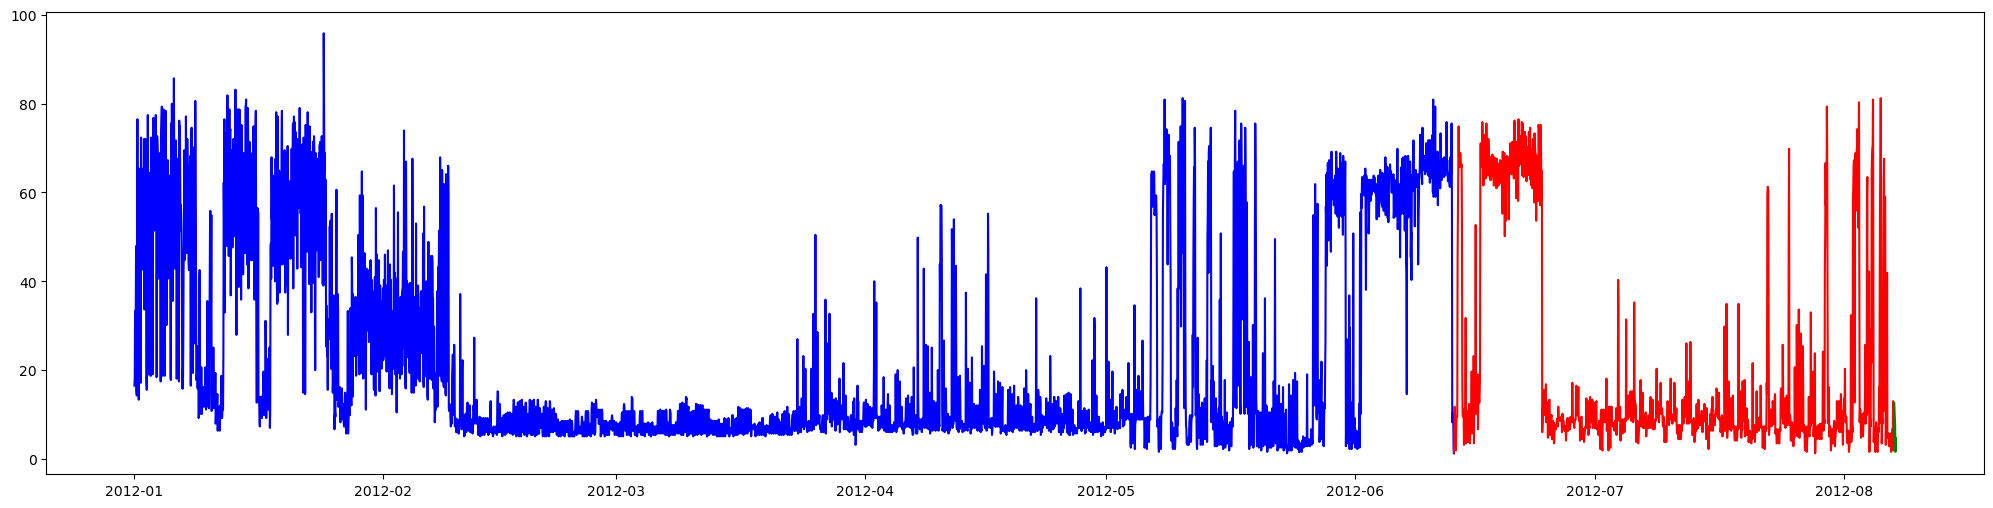

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,6))

plt.plot(train_df.loc[:, ['customer_0']], c='blue')
plt.plot(val_df.loc[:, ['customer_0']], c='red')
plt.plot(test_df.loc[:, ['customer_0']], c='green')

### Attention Models

In [10]:
import torch
import torch.nn as nn

from torch.nn import functional as F
# from pytorch_forecasting.metrics import QuantileLoss

In [11]:
# torch.manual_seed(101)
def get_batch(split):
    df = train_df if split == 'train' else val_df
    
    idx_start = torch.randint(0, len(df['customer_0']) - context_window - forecast_window, (batch_size,))
    customer = torch.tensor(df['customer_0'])

    x_batch = torch.stack([customer[idx:idx+context_window] for idx in idx_start])
    y_batch = torch.stack([customer[idx+context_window:idx+context_window+forecast_window] for idx in idx_start])

    x_batch = x_batch.view((batch_size, context_window, 1))
    y_batch = y_batch.view((batch_size, forecast_window, 1))
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    return x_batch, y_batch


@torch.no_grad() # prevents pytorch from running backpropagation
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X,Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out
    

In [12]:
# Base Transformer Model for timeseries Multi-step forecast
class Head(nn.Module):
    def __init__(self, head_size) -> None:
        super().__init__()

        self.key = nn.Linear(n_customers, head_size, bias=False)
        self.query = nn.Linear(n_customers, head_size, bias=False)
        self.value = nn.Linear(n_customers, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer('tril', torch.tril(torch.ones(context_window, context_window))) # not a parameter of the model, so create it with register_buffer.
    
    def forward(self, x):
        B,T,C = x.shape
        
        k = self.key(x)
        q = self.query(x)

        # attention affinities
        weights = q @ k.transpose(-2, -1) * C ** -0.5  # (B, T, T)
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # This is the form of guaranteeing future time tokens do not communicate with former tokens.
        weights = F.softmax(weights, dim=-1)
        
        weights = self.dropout(weights)

        v = self.value(x) # B, T, head_size
        out = weights @ v # (B,T,T) @ (B,T,head_size) = (B, T, head_size)
        return out


class timeseries_model(nn.Module):
    def __init__(self, head_size):
        super().__init__()

        self.head = Head(head_size) # 32, 64, 128
        self.layer_norm_1 = nn.LayerNorm(head_size) # 32, 64, 128
        self.transpose_proj = nn.Linear(context_window, n_customers) # 32, 128, 64 
        self.proj = nn.Linear(head_size, n_customers) # 32, 64, 1
        
        self.layer_norm_2 = nn.LayerNorm(n_customers) # 32, 64, 1

        self.quantile_forecasts = nn.ModuleList([nn.Linear(head_size, 3) for i in range(forecast_window)])
                                        
    def forward(self, x, target=None):
        x = self.head(x) # 32, 64, 128
        x = self.layer_norm_1(x) # 32, 64, 128
        x = self.transpose_proj(x.transpose(-2,-1)) # 32, 128, 1 
        x = x.transpose(-2,-1) # 32, 1, 128
        
        # logits = torch.cat([qf(x) for qf in self.quantile_forecasts], dim=-1) # 32, 64 3*forecast_window
        logits = torch.stack([qf(x) for qf in self.quantile_forecasts], dim=-1) # 32, 64 3*forecast_window
        if target is None:
            loss = None
        else:
            loss = self.quantile_loss_function(logits.squeeze(), target.view(batch_size, 1, -1))

        return logits, loss

    def quantile_loss_function(self, predictions, target, quantiles=[0.05, 0.5, 0.95]):
        q = torch.tensor(quantiles).view(-1,1).to(device)
        result = torch.maximum(q*(target - predictions), (1-q)*(predictions - target))
        result = result.sum(dim=-1)
        result = result.mean()
        return result

In [37]:
n_customers = 1
batch_size = 32
context_window = 256
forecast_window = 64
head_size = 128
n_heads = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

learning_rate = 3e-4
dropout = 0.2

max_iters = 5000
eval_interval = 500
eval_iters = 5

class Head(nn.Module):
    def __init__(self, head_size) -> None:
        super().__init__()

        self.key = nn.Linear(n_customers, head_size, bias=False)
        self.query = nn.Linear(n_customers, head_size, bias=False)
        self.value = nn.Linear(n_customers, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer('tril', torch.tril(torch.ones(context_window, context_window))) # not a parameter of the model, so create it with register_buffer.
    
    def forward(self, x):
        B,T,C = x.shape
        
        k = self.key(x) # B, T, head_size
        q = self.query(x) # B, T, head_size

        # attention affinities
        weights = q @ k.transpose(-2, -1) * C ** -0.5  # (B, T, T)
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # This is the form of guaranteeing future time tokens do not communicate with former tokens.
        weights = F.softmax(weights, dim=-1)
        
        weights = self.dropout(weights)

        v = self.value(x) # B, T, head_size
        out = weights @ v # (B,T,T) @ (B,T,head_size) = (B, T, head_size)
        
        return out

# Multi-head Transformer Model for timeseries Multi-step forecast
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)]) # (B, T, head_size)
        self.proj = nn.Linear(n_heads * head_size, n_heads* head_size) # 32, 64, 128
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # B,T, head_size
        out = self.proj(out)
        out = self.dropout(out)
        return out
        
class timeseries_model_v2(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()

        self.multi_head = MaskedMultiHeadAttention(n_heads, head_size // n_heads) # 32, 256, head_size
        self.layer_norm_1 = nn.LayerNorm(head_size) # 32, 256, head_size
        self.transpose_proj = nn.Linear(context_window, head_size) # 32, head_size, head_size 
        self.proj = nn.Linear(head_size, n_customers) # 32, head_size, 1
        self.layer_norm_2 = nn.LayerNorm(n_customers) # 32, head_size, 1

        self.quantile_forecasts = nn.ModuleList([nn.Linear(head_size, 3) for i in range(forecast_window)])
                                        
    def forward(self, x, target=None):
        x = self.multi_head(x) # 32, 256, 256
        x = self.layer_norm_1(x) # 32, 256, 256
        x = self.transpose_proj(x.transpose(-2,-1)) # 32, 256, 256 
        x = self.proj(x) # 32, 256, 1
        x = self.layer_norm_2(x) # 32, 256, 1
        x = x.transpose(-2,-1) #32, 1, 256
        
        # logits = torch.cat([qf(x) for qf in self.quantile_forecasts], dim=-1) # 32, context_window, 3*forecast_window
        logits = torch.stack([qf(x) for qf in self.quantile_forecasts], dim=-1) # 32, context_window, 3*forecast_window
        
        if target is None:
            loss = None
        else:
            loss = self.quantile_loss_function(logits.squeeze(), target.view(batch_size, 1, -1))

        return logits, loss

    def quantile_loss_function(self, predictions, target, quantiles=[0.05, 0.5, 0.95]):
        q = torch.tensor(quantiles).view(-1,1).to(device)
        result = torch.maximum(q*(target - predictions), (1-q)*(predictions - target))
        result = result.sum(dim=-1)
        result = result.mean()
        return result

In [38]:
%%time

n_customers = 1
batch_size = 32
context_window = 256
forecast_window = 64
head_size = 256
n_heads = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

learning_rate = 3e-4
dropout = 0.2

max_iters = 5000
eval_interval = 500
eval_iters = 5

model = timeseries_model_v2(n_heads, head_size)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

losses = []
for i in range(max_iters):
    if i % eval_interval == 0:
        eval_losses = estimate_loss()
        print(f'Step {iter}: train loss {eval_losses["train"]:.4f}, val loss {eval_losses["val"]:.4f}')
        
    x_batch, y_batch = get_batch('train')
    
    logits, loss = model(x_batch, y_batch)
    losses.append(loss.detach().cpu())
    # print(f'Step {i}: train loss {loss:.4f}')
    
    optimizer.zero_grad(set_to_none=True)
    
    loss.backward()
    optimizer.step()

Step <built-in function iter>: train loss 684.2080, val loss 347.8184
Step <built-in function iter>: train loss 434.7791, val loss 165.6666
Step <built-in function iter>: train loss 334.5443, val loss 137.4526
Step <built-in function iter>: train loss 249.9216, val loss 128.7273
Step <built-in function iter>: train loss 218.0236, val loss 122.0930
Step <built-in function iter>: train loss 223.1759, val loss 129.0857
Step <built-in function iter>: train loss 232.4423, val loss 134.3947
Step <built-in function iter>: train loss 208.1203, val loss 124.8737
Step <built-in function iter>: train loss 214.5905, val loss 124.0995
Step <built-in function iter>: train loss 232.0687, val loss 123.0842
CPU times: user 2min 54s, sys: 7.21 s, total: 3min 1s
Wall time: 3min


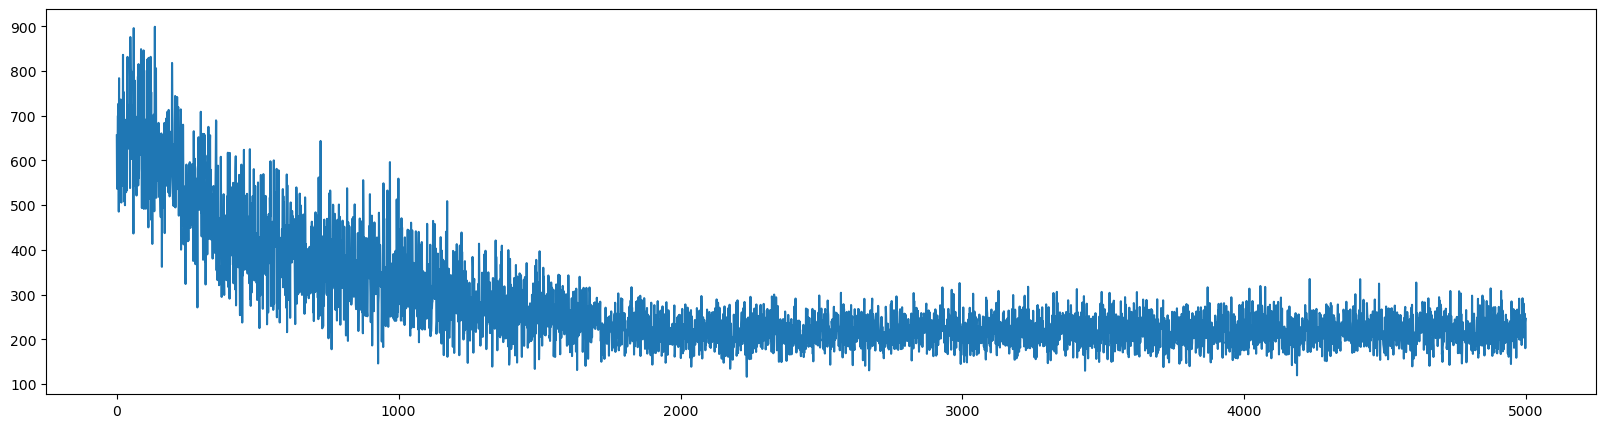

In [39]:
plt.figure(figsize=(20,5))
plt.plot(torch.tensor(losses))

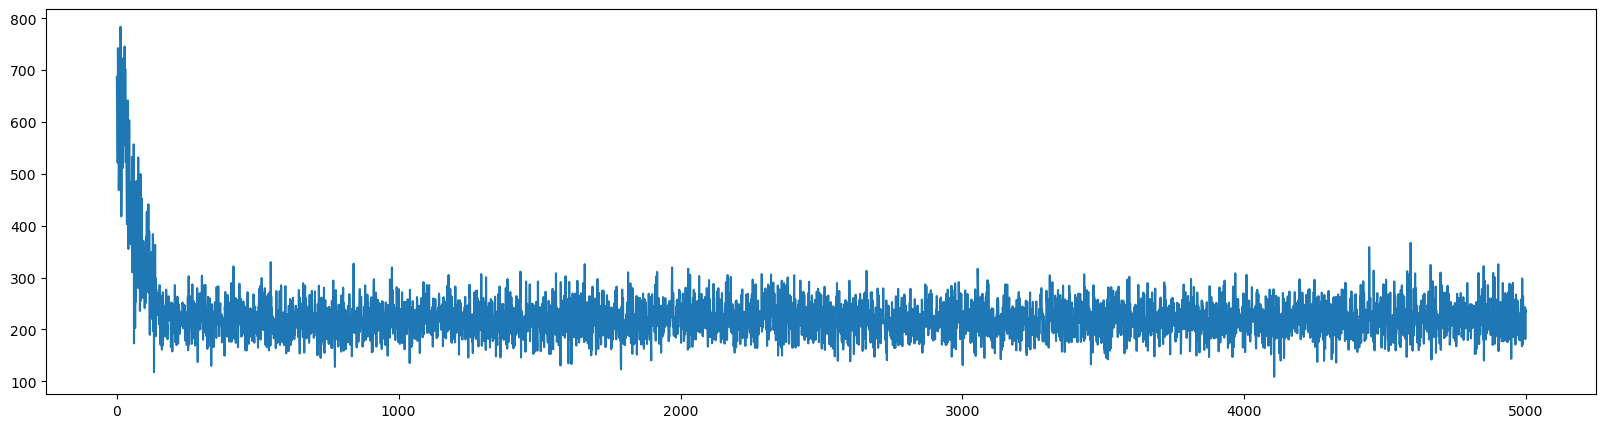

In [129]:
plt.figure(figsize=(20,5))
plt.plot(torch.tensor(losses))

In [44]:
torch.manual_seed(10001)
idx_start = torch.randint(0, len(val_df['customer_0']) - context_window - forecast_window, (1,))
customer = torch.tensor(val_df['customer_0'])

x_val = torch.stack([customer[idx:idx+context_window] for idx in idx_start])
y_val = torch.stack([customer[idx+context_window:idx+context_window+forecast_window] for idx in idx_start])

x_val = x_val.view((1, -1, 1)).to(device)
# y_val = y_val.view((1, -1, 1)).to(device)

In [45]:
print(x_val.shape)
print(y_val.shape)

torch.Size([1, 256, 1])
torch.Size([1, 64])


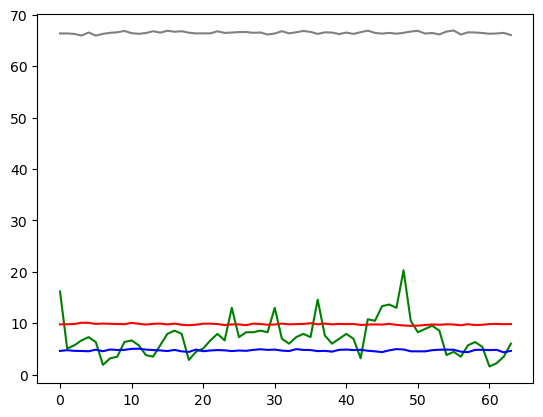

In [46]:
y_pred, _ = model(x_val)
y_pred_lb, y_pred, y_pred_ub = y_pred.view(3, 64)

# Valores reais
plt.plot(y_val.view(-1).detach().cpu(), c='green')

# predictions
plt.plot(y_pred_lb.detach().cpu(), c='blue')
plt.plot(y_pred.detach().cpu(), c='red')
plt.plot(y_pred_ub.detach().cpu(), c='gray')

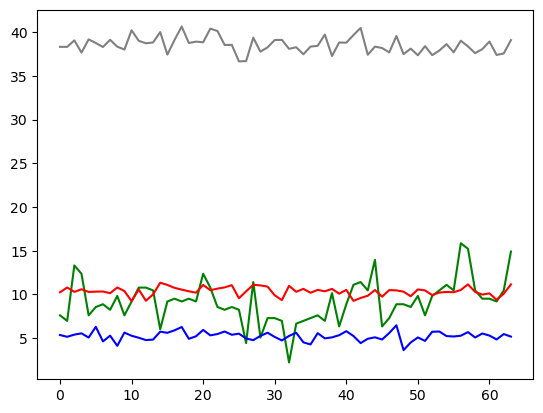

In [34]:
y_pred, _ = model(x_val)
y_pred_lb, y_pred, y_pred_ub = y_pred.view(3, 64)

# Valores reais
plt.plot(y_val.view(-1).detach().cpu(), c='green')

# predictions
plt.plot(y_pred_lb.detach().cpu(), c='blue')
plt.plot(y_pred.detach().cpu(), c='red')
plt.plot(y_pred_ub.detach().cpu(), c='gray')

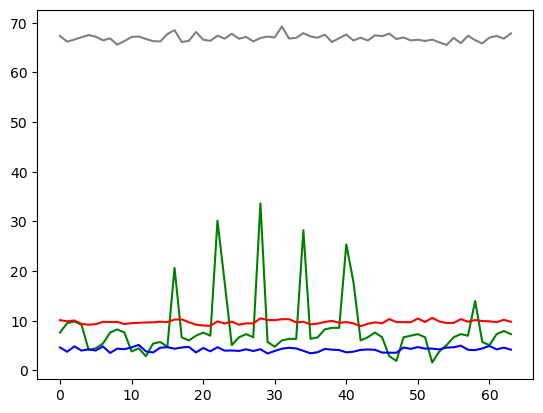

In [133]:
y_pred, _ = model(x_val)
y_pred_lb, y_pred, y_pred_ub = y_pred.view(3, 64)

# Valores reais
plt.plot(y_val.view(-1).detach().cpu(), c='green')

# predictions
plt.plot(y_pred_lb.detach().cpu(), c='blue')
plt.plot(y_pred.detach().cpu(), c='red')
plt.plot(y_pred_ub.detach().cpu(), c='gray')

In [ ]:
## Aumentar cabeças de atenção e verificar se o resultado melhora.